# Group 14
Marcel de Beer - 18019252

Jeanri Jooste - 18043233

Vinayak Mangalmurti - 18048766

Nicola van Rensburg - 18007229

Rowlandi Verwey - 19348003

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from ipywidgets import interact
import matplotlib.pyplot as plt
%matplotlib inline

# Question Given
<img src="Question.jpg" width="600" />

# Additional Information Given
<img src="Information.jpg" width="600" />

# Investigation 1
<img src="Investigation 1.jpg" width="600" />

In [2]:
#Info Given
'Heat Capacities - [J/mol.K]'
Cpm = 68 #Methane - M
Cpe = 90 #Ethylene - E
Cpb = 201 #Benzene - B
Cpt = 249 #Toluene - T
Cpst = 273 #Styrene - St
Cpeb = 299 #Ethylbenzene - EB
Cph2 = 30 #Hydrogen - H2
Cps = 40 #Steam - S

'Reactions'
rhoc = 2137 #kg/m3
phi = 0.4
delH1 = 118000 #kJ/kmol EB
delH2 = 105200 #kJ/kmol EB
delH3 = -53900 #kJ/kmol EB

'Equilibrium Constant Variables'
b1 = -17.34
b2 = -1.302e4
b3 = 5.051
b4 = -2.314e-10
b5 = 1.302e-6
b6 = -4.931e-3

'Reactor Data'
FEBo = 0.00344 #kmol/s
V = 10 #m3
Po = 2.4 #atm
Ua = 100/60 #kJ/(m3.K.s)
Tu = 1000 #K

# Equations
Reaction 1:
$$EthylBenzene \rightleftharpoons Styrene + H_2$$

Reaction 2:
$$EthylBenzene \to Benzene + Ethylene$$

Reaction 3:
$$EthylBenzene + H_2 \to Toluene + Methane$$

Reaction Rates:
$$r_{1St} = ρ_bexp(-0.08539 - \frac{10925}{T})(P_{EB} - \frac{P_{St}P_{H_2}}{K_{p1}})$$

$$r_{2B} = ρ_bexp(13.2392 - \frac{25000}{T})(P_{EB})$$

$$r_{3T} = ρ_bexp(0.2961 - \frac{11000}{T})(P_{EB}P_{H_2})$$

Bed Density:
$$ρ_b = ρ_c(1-φ)$$

Equilibrium Constant:
$$K_{p1} = exp(b_1 + \frac{b_2}{T} + b_3ln(T) + [(b_4T + b_5)T + b_6]T)$$

Partial Pressure:
$$P_i = \frac{F_i}{F_T}P_{Tot}$$

Energy Balance:
$$ \frac{dT}{dV} = - \sum_j^r \frac{ dF_{ij}} {ν_{ij} dV} \left( \frac{ΔH_{rxj; 298} + ΔCp_{rxj}(T - 298) } {\sum_i^{k} F_iCp_i } \right) $$
$$ \frac{dF_i}{dV} = r_i $$

$$ \frac{dT}{dV} = \frac{ Ua(Tu - T)  - \sum_j^r \frac{ dF_{ij}} {ν_{ij} dV} \left( ΔH_{rxj; 298} + ΔCp_{rxj}(T - 298) \right) } {\sum_i^k F_iCp_i }  $$

Selectivity:
$$S = \frac{F_{Styrene}}{F_{Toluene} + F_{Benzene}}$$

In [3]:
rhob = rhoc * (1 - phi)

'Reaction Rates'
def rates(var, T):
    Fm, Fe, Fb, Ft, Fst, Feb, Fh2, Fs = var
    FT = Fm + Fe + Fb + Ft + Fst + Feb + Fh2 + Fs
    
    'Partial Pressures'
    Peb = (Feb/FT) * Po
    Pst = (Fst/FT) * Po
    Ph2 = (Fh2/FT) * Po
    
    'Equilibrium Constant'
    K = np.exp(b1 + b2/T + b3*np.log(T) + ((b4*T + b5)*T + b6)*T)
    
    'Reaction rates'
    r1St = rhob * np.exp(-0.08539 - 10925/T) * (Peb - (Pst*Ph2)/K)
    r2B = rhob * np.exp(13.2392 - 25000/T) * Peb
    r3T = rhob * np.exp(0.2961 - 11000/T) * (Peb*Ph2)
    R = np.array([-r1St, -r2B, -r3T])
    
    'Reaction 1'
    r1EB = -r1St
    r1H2 = r1St
    
    'Reaction 2'
    r2EB = -r2B
    r2E = r2B
    
    'Reaction 3'
    r3EB = -r3T
    r3H2 = -r3T
    r3M = r3T
    
    'Component Rates'
    rM = r3M
    rE = r2E
    rB = r2B
    rT = r3T
    rSt = r1St
    rEB = r1EB + r2EB + r3EB
    rH2 = r1H2 + r3H2
    rS = 0
    
    return rM, rE, rB, rT, rSt, rEB, rH2, rS, R

In [4]:
'PFR Reactor'
def PFR(V, var):
    Fm, Fe, Fb, Ft, Fst, Feb, Fh2, Fs, T = var
    F = np.array([Fm, Fe, Fb, Ft, Fst, Feb, Fh2, Fs])
    rM, rE, rB, rT, rSt, rEB, rH2, rS, dFdV = rates(F, T)
    
    'Algebraic Equations'
    muEB1 = muEB2 = muEB3 = muEB = -1
    FCp = Fm*Cpm + Fe*Cpe + Fb*Cpb + Ft*Cpt + Fst*Cpst + Feb*Cpeb + Fh2*Cph2 + Fs*Cps
    
    'Heat Capacities for each Reaction'
    CP1 = Cpst + Cph2 - Cpeb
    CP2 = Cpb + Cpe - Cpeb
    CP3 = Cpt + Cpm - Cph2 - Cpeb
    
    'Heat of Reaction for each Reaction'
    H1 = delH1 + CP1*(T - 298)
    H2 = delH2 + CP2*(T - 298)
    H3 = delH3 + CP3*(T - 298)
    
    'Reaction rates of each Reaction'
    r1 = -rSt
    r2 = -rB
    r3 = -rT
    
    'Epsilon values'
    eps1 = r1/muEB1
    eps2 = r2/muEB2
    eps3 = r3/muEB3
    
    'Differential Equations'
    dFmdV = rM
    dFedV = rE
    dFbdV = rB
    dFtdV = rT
    dFstdV = rSt
    dFebdV = rEB
    dFh2dV = rH2
    dFsdV = rS
    dTdV = 0
    
    return dFmdV, dFedV, dFbdV, dFtdV, dFstdV, dFebdV, dFh2dV, dFsdV, dTdV

In [5]:
'Temperature range and Ratio range'
Trange = np.linspace(700, 1000)
Rrange = np.linspace(20, 50)

'Empty lists'
Tolist = []
Rlist = []
Slist = []
FStlist = []
FEBlist = []
FBlist = []
FTlist = []

for i in range(len(Trange)):
    for j in range(len(Rrange)):
        To = Trange[i]
        ratio = Rrange[j]
        
        'Initial Values'
        FSo = FEBo*ratio
        FMo = 0
        FEo = 0
        FBo = 0
        FTo = 0
        FSto = 0
        FH2o = 0
        initial = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo, To]
        Vrange = [0, V]
        Vspan = np.linspace(0, V)

        ans = solve_ivp(PFR, Vrange, initial, dense_output = True)
        ans1 = ans.sol(Vspan)
        FM, FE, FB, FT, FSt, FEB, FH2, FS, T = ans1

        S = FSt[-1]/(FB[-1] + FT[-1])
        
        
        'Append Values'
        FStlist.append(FSt[-1])
        FEBlist.append(FEB[-1])
        FBlist.append(FB[-1])
        FTlist.append(FT[-1])
        Slist.append(S)
        Tolist.append(To)
        Rlist.append(ratio)
    

'Find Maximum Styrene Production and corresponding Temperature, ratio and selectivity'
FStrange = np.array(FStlist)
FEBrange = np.array(FEBlist)
FBrange = np.array(FBlist)
FTrange = np.array(FTlist)
Srange = np.array(Slist)
Torange = np.array(Tolist)
Rorange = np.array(Rlist)

FSTmax = max(FStrange)
SOpt = Srange[FSTmax == FStlist]
TOpt = Torange[FSTmax == FStlist]
rOpt = Rorange[FSTmax == FStlist]

R1range = np.linspace(20, 50, 2500)
T1range = np.linspace(700, 1000, 2500)

# Solve for optimal values

In [38]:
'Initial Values'
FSo1 = FEBo*rOpt
FMo = 0
FEo = 0
FBo = 0
FTo = 0
FSto = 0
FH2o = 0
initial1 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo1, TOpt]
Vrange1 = [0, V]
Vspan1 = np.linspace(0, 10, 2500)

ans2 = solve_ivp(PFR, Vrange1, initial1, dense_output = True)
ans3 = ans2.sol(Vspan1)
FM1, FE1, FB1, FT1, FSt1, FEB1, FH21, FS1, T1 = ans3

S1 = FSt1/(FB1 + FT1)
x1 = (FEBo - FEB1[-1])/FEBo

'Find the Energy needed'
mu = muS = muB = muT = 1
eps1 = (FSt1[-1] - FSto)/mu #Reaction 1 - Styrene rate
eps2 = (FB1[-1] - FBo)/mu #Reaction 2 - Benzene rate
eps3 = (FT1[-1] - FTo)/mu #Reaction 3 - Toluene rate
Q = (eps1*delH1 + eps2*delH2 + eps3*delH3)

'Find The Utility Temperature'
Tu = TOpt[0] + Q/Ua

FSoOpt = FEBo * rOpt

C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-38-6892d0089302>:17: RuntimeWarning: invalid value encountered in true_divide
  S1 = FSt1/(FB1 + FT1)


# Optimal Values

In [41]:
print(f'The initial Temperature, To = {np.round(TOpt[0])} K')
print(f'Flowrate of Steam, F = {np.round(FSoOpt[0]*1000, 1)} mol/s')
print(f'Flowrate of Styrene, Fs = {np.round(FSTmax*1000, 3)} mol/s')
print(f'Flowrate of Benzene, Fb = {np.round(FB1[-1]*1000, 3)} mol/s')
print(f'Flowrate of Toluene, Ft = {np.round(FT1[-1]*1000, 3)} mol/s')
print(f'The selectivity is, S = {np.round(S1[-1], 2)} mol/mol')
print(f'Ratio of Steam:Ethylbenzene, r = {np.round(rOpt[0], 1)} mol/mol')
print(f'Conversion of reactor, x = {np.round(x1*100, 1)}%')
print(f'The energy needed, Q = {np.round(Q, 2)} kW')
print(f'Utility Temperature, Tu = {np.round(Tu)} K')

The initial Temperature, To = 939.0 K
Flowrate of Steam, F = 94.1 mol/s
Flowrate of Styrene, Fs = 2.508 mol/s
Flowrate of Benzene, Fb = 0.531 mol/s
Flowrate of Toluene, Ft = 0.122 mol/s
The selectivity is, S = 3.84 mol/mol
Ratio of Steam:Ethylbenzene, r = 27.3 mol/mol
Conversion of reactor, x = 91.9%
The energy needed, Q = 345.16 kW
Utility Temperature, Tu = 1146.0 K


In [8]:
rval = np.linspace(20, 50, 500)
F939 = []
S939 = []

for r in rval:
    'Initial Values'
    T939 = 939 #K
    FSo = FEBo*r
    FMo = 0
    FEo = 0
    FBo = 0
    FTo = 0
    FSto = 0
    FH2o = 0
    initial93 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo, T939]
    Vrange = [0, V]
    Vspan93 = np.linspace(0, 10)

    A4 = solve_ivp(PFR, Vrange, initial93, dense_output = True)
    B4 = A4.sol(Vspan93)
    FM93, FE93, FB93, FT93, FSt93, FEB93, FH293, FS93, T93 = B4
    s939 = FSt93[-1]/(FT93[-1] + FB93[-1])
    
    'Append Values'
    S939.append(s939)
    F939.append(FSt93[-1])

# Plot Graphs

## Volume vs Flowrate

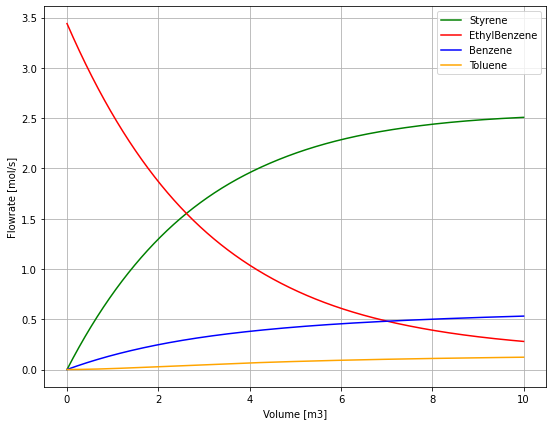

In [9]:
plt.figure(7, figsize = (9, 7))
plt.plot(Vspan1, FSt1*1000, color = 'green', label = 'Styrene')
plt.plot(Vspan1, FEB1*1000, color = 'red', label = 'EthylBenzene')
plt.plot(Vspan1, FB1*1000, color = 'blue', label = 'Benzene')
plt.plot(Vspan1, FT1*1000, color = 'orange', label = 'Toluene')
plt.legend(loc = 'best')
plt.xlabel('Volume [m3]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

# Different Temperature Values

## 900K

The initial Temperature, To = 900 K
Flowrate of Styrene, Fs = 2.32 mol/s
Flowrate of Benzene, Fb = 0.255 mol/s
Flowrate of Toluene, Ft = 0.103 mol/s
The selectivity is, S = 6.47 mol/mol
Ratio of Steam:Ethylbenzene, r = 27.3 mol/mol
Conversion of reactor, x = 77.9%


C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-10-14630fc395a0>:19: RuntimeWarning: invalid value encountered in true_divide
  S2 = FSt2/(FB2 + FT2)


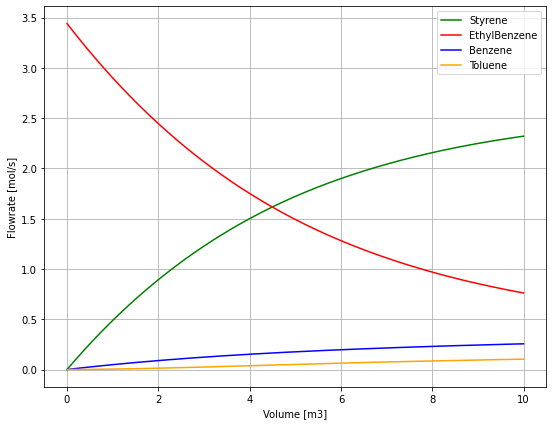

In [10]:
'Initial Values'
To2 = 900 #K
FSo2 = FEBo*rOpt
FMo = 0
FEo = 0
FBo = 0
FTo = 0
FSto = 0
FH2o = 0
initial2 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo2, 900]
Vrange2 = [0, V]
Vspan2 = np.linspace(0, 10, 2500)

ans4 = solve_ivp(PFR, Vrange2, initial2, dense_output = True)
ans5 = ans4.sol(Vspan2)
FM2, FE2, FB2, FT2, FSt2, FEB2, FH22, FS2, T2 = ans5

FST2 = max(FSt2)
S2 = FSt2/(FB2 + FT2)
x2 = (FEBo - FEB2[-1])/FEBo

print(f'The initial Temperature, To = {np.round(To2)} K')
print(f'Flowrate of Styrene, Fs = {np.round(FSt2[-1]*1000, 3)} mol/s')
print(f'Flowrate of Benzene, Fb = {np.round(FB2[-1]*1000, 3)} mol/s')
print(f'Flowrate of Toluene, Ft = {np.round(FT2[-1]*1000, 3)} mol/s')
print(f'The selectivity is, S = {np.round(S2[-1], 2)} mol/mol')
print(f'Ratio of Steam:Ethylbenzene, r = {np.round(rOpt[0], 1)} mol/mol')
print(f'Conversion of reactor, x = {np.round(x2*100, 1)}%')

plt.figure(8, figsize = (9, 7))
plt.plot(Vspan2, FSt2*1000, color = 'green', label = 'Styrene')
plt.plot(Vspan2, FEB2*1000, color = 'red', label = 'EthylBenzene')
plt.plot(Vspan2, FB2*1000, color = 'blue', label = 'Benzene')
plt.plot(Vspan2, FT2*1000, color = 'orange', label = 'Toluene')
plt.legend(loc = 'best')
plt.xlabel('Volume [m3]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

In [11]:
rval = np.linspace(20, 50, 500)
F900 = []
S900 = []

for r in rval:
    'Initial Values'
    T900 = 900 #K
    FSo = FEBo*r
    FMo = 0
    FEo = 0
    FBo = 0
    FTo = 0
    FSto = 0
    FH2o = 0
    initial9 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo, T900]
    Vrange = [0, V]
    Vspan9 = np.linspace(0, 10)

    A = solve_ivp(PFR, Vrange, initial9, dense_output = True)
    B = A.sol(Vspan9)
    FM9, FE9, FB9, FT9, FSt9, FEB9, FH29, FS9, T9 = B
    s900 = FSt9[-1]/(FT9[-1] + FB9[-1])
    
    'Append Values'
    S900.append(s900)
    F900.append(FSt9[-1])

## 950K

The initial Temperature, To = 950 K
Flowrate of Styrene, Fs = 2.493 mol/s
Flowrate of Benzene, Fb = 0.63 mol/s
Flowrate of Toluene, Ft = 0.121 mol/s
The selectivity is, S = 3.32 mol/mol
Ratio of Steam:Ethylbenzene, r = 27.3 mol/mol
Conversion of reactor, x = 94.3%


C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-12-46ce18fd4369>:19: RuntimeWarning: invalid value encountered in true_divide
  S3 = FSt3/(FB3 + FT3)


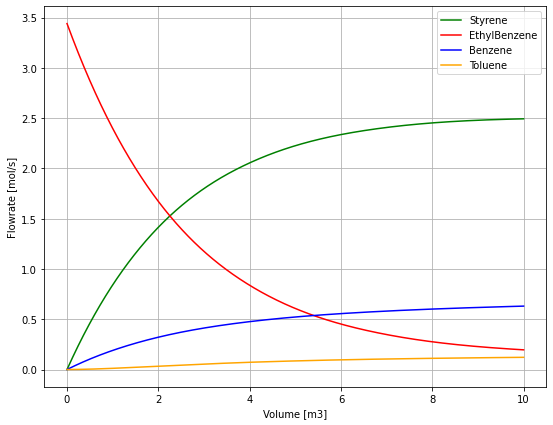

In [12]:
'Initial Values'
To3 = 950 #K
FSo3 = FEBo*rOpt
FMo = 0
FEo = 0
FBo = 0
FTo = 0
FSto = 0
FH2o = 0
initial3 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo3, 950]
Vrange3 = [0, V]
Vspan3 = np.linspace(0, 10, 2500)

ans6 = solve_ivp(PFR, Vrange3, initial3, dense_output = True)
ans7 = ans6.sol(Vspan3)
FM3, FE3, FB3, FT3, FSt3, FEB3, FH23, FS3, T3 = ans7

FST3 = max(FSt3)
S3 = FSt3/(FB3 + FT3)
x3 = (FEBo - FEB3[-1])/FEBo

print(f'The initial Temperature, To = {np.round(To3)} K')
print(f'Flowrate of Styrene, Fs = {np.round(FST3*1000, 3)} mol/s')
print(f'Flowrate of Benzene, Fb = {np.round(FB3[-1]*1000, 3)} mol/s')
print(f'Flowrate of Toluene, Ft = {np.round(FT3[-1]*1000, 3)} mol/s')
print(f'The selectivity is, S = {np.round(S3[-1], 2)} mol/mol')
print(f'Ratio of Steam:Ethylbenzene, r = {np.round(rOpt[0], 1)} mol/mol')
print(f'Conversion of reactor, x = {np.round(x3*100, 1)}%')

plt.figure(9, figsize = (9, 7))
plt.plot(Vspan3, FSt3*1000, color = 'green', label = 'Styrene')
plt.plot(Vspan3, FEB3*1000, color = 'red', label = 'EthylBenzene')
plt.plot(Vspan3, FB3*1000, color = 'blue', label = 'Benzene')
plt.plot(Vspan3, FT3*1000, color = 'orange', label = 'Toluene')
plt.legend(loc = 'best')
plt.xlabel('Volume [m3]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

In [46]:
rval = np.linspace(20, 50, 500)
F950 = []
S950 = []

for r in rval:
    'Initial Values'
    T950 = 950 #K
    FSo95 = FEBo*r
    FMo = 0
    FEo = 0
    FBo = 0
    FTo = 0
    FSto = 0
    FH2o = 0
    initial95 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo95, T950]
    Vrange = [0, V]
    Vspan95 = np.linspace(0, 10)

    A1 = solve_ivp(PFR, Vrange, initial95, dense_output = True)
    B1 = A1.sol(Vspan95)
    FM95, FE95, FB95, FT95, FSt95, FEB95, FH295, FS95, T95 = B1
    s950 = FSt95[-1]/(FT95[-1] + FB95[-1])
    
    'Append Values'
    S950.append(s950)
    F950.append(FSt95[-1])

## 1000K

The initial Temperature, To = 1000 K
Flowrate of Styrene, Fs = 2.195 mol/s
Flowrate of Benzene, Fb = 1.137 mol/s
Flowrate of Toluene, Ft = 0.092 mol/s
The selectivity is, S = 1.77 mol/mol
Ratio of Steam:Ethylbenzene, r = 27.3 mol/mol
Conversion of reactor, x = 98.9%


C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-14-0a0aef8465ec>:19: RuntimeWarning: invalid value encountered in true_divide
  S4 = FSt4/(FB4 + FT4)


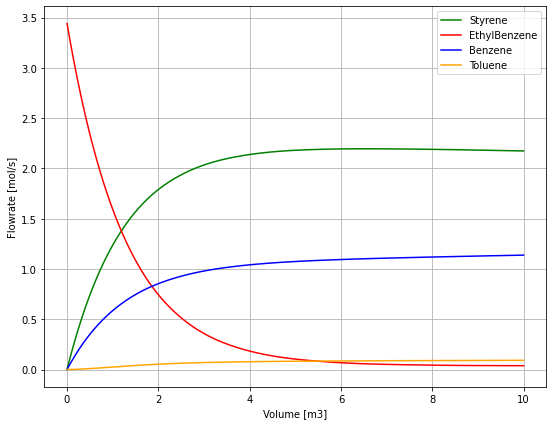

In [14]:
'Initial Values'
To4 = 1000 #K
FSo3 = FEBo*rOpt
FMo = 0
FEo = 0
FBo = 0
FTo = 0
FSto = 0
FH2o = 0
initial4 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo3, 1000]
Vrange4 = [0, V]
Vspan4 = np.linspace(0, 10, 2500)

ans8 = solve_ivp(PFR, Vrange4, initial4, dense_output = True)
ans9 = ans8.sol(Vspan3)
FM4, FE4, FB4, FT4, FSt4, FEB4, FH24, FS4, T4 = ans9

FST4 = max(FSt4)
S4 = FSt4/(FB4 + FT4)
x4 = (FEBo - FEB4[-1])/FEBo

print(f'The initial Temperature, To = {np.round(To4)} K')
print(f'Flowrate of Styrene, Fs = {np.round(FST4*1000, 3)} mol/s')
print(f'Flowrate of Benzene, Fb = {np.round(FB4[-1]*1000, 3)} mol/s')
print(f'Flowrate of Toluene, Ft = {np.round(FT4[-1]*1000, 3)} mol/s')
print(f'The selectivity is, S = {np.round(S4[-1], 2)} mol/mol')
print(f'Ratio of Steam:Ethylbenzene, r = {np.round(rOpt[0], 1)} mol/mol')
print(f'Conversion of reactor, x = {np.round(x4*100, 1)}%')

plt.figure(10, figsize = (9, 7))
plt.plot(Vspan4, FSt4*1000, color = 'green', label = 'Styrene')
plt.plot(Vspan4, FEB4*1000, color = 'red', label = 'EthylBenzene')
plt.plot(Vspan4, FB4*1000, color = 'blue', label = 'Benzene')
plt.plot(Vspan4, FT4*1000, color = 'orange', label = 'Toluene')
plt.legend(loc = 'best')
plt.xlabel('Volume [m3]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

In [45]:
rval = np.linspace(20, 50, 500)
F1000 = []
S1000 = []

for r in rval:
    'Initial Values'
    T1000 = 1000 #K
    FSo100 = FEBo*r
    FMo = 0
    FEo = 0
    FBo = 0
    FTo = 0
    FSto = 0
    FH2o = 0
    initial100 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo100, T1000]
    Vrange = [0, V]
    Vspan100 = np.linspace(0, 10)

    A2 = solve_ivp(PFR, Vrange, initial100, dense_output = True)
    B2 = A2.sol(Vspan100)
    FM100, FE100, FB100, FT100, FSt100, FEB100, FH2100, FS100, T100 = B2
    s100 = FSt100[-1]/(FT100[-1] + FB100[-1])
    
    'Append Values'
    S1000.append(s100)
    F1000.append(FSt100[-1])

## 850K

The initial Temperature, To = 850 K
Flowrate of Styrene, Fs = 1.658 mol/s
Flowrate of Benzene, Fb = 0.071 mol/s
Flowrate of Toluene, Ft = 0.05 mol/s
The selectivity is, S = 13.62 mol/mol
Ratio of Steam:Ethylbenzene, r = 27.3 mol/mol
Conversion of reactor, x = 51.7%


C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\debee\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
<ipython-input-16-f0c17b2cdfaa>:19: RuntimeWarning: invalid value encountered in true_divide
  S5 = FSt5/(FB5 + FT5)


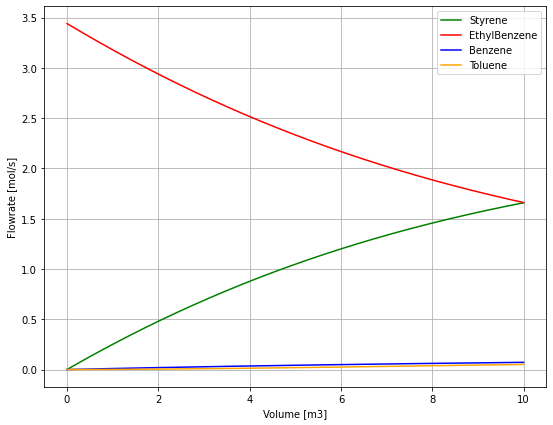

In [16]:
'Initial Values'
To5 = 850 #K
FSo3 = FEBo*rOpt
FMo = 0
FEo = 0
FBo = 0
FTo = 0
FSto = 0
FH2o = 0
initial5 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo3, 850]
Vrange5 = [0, V]
Vspan5 = np.linspace(0, 10, 2500)

ans10 = solve_ivp(PFR, Vrange5, initial5, dense_output = True)
ans11 = ans10.sol(Vspan5)
FM5, FE5, FB5, FT5, FSt5, FEB5, FH25, FS5, T5 = ans11

FST5 = max(FSt5)
S5 = FSt5/(FB5 + FT5)
x5 = (FEBo - FEB5[-1])/FEBo

print(f'The initial Temperature, To = {np.round(To5)} K')
print(f'Flowrate of Styrene, Fs = {np.round(FST5*1000, 3)} mol/s')
print(f'Flowrate of Benzene, Fb = {np.round(FB5[-1]*1000, 3)} mol/s')
print(f'Flowrate of Toluene, Ft = {np.round(FT5[-1]*1000, 3)} mol/s')
print(f'The selectivity is, S = {np.round(S5[-1], 2)} mol/mol')
print(f'Ratio of Steam:Ethylbenzene, r = {np.round(rOpt[0], 1)} mol/mol')
print(f'Conversion of reactor, x = {np.round(x5*100, 1)}%')

plt.figure(11, figsize = (9, 7))
plt.plot(Vspan5, FSt5*1000, color = 'green', label = 'Styrene')
plt.plot(Vspan5, FEB5*1000, color = 'red', label = 'EthylBenzene')
plt.plot(Vspan5, FB5*1000, color = 'blue', label = 'Benzene')
plt.plot(Vspan5, FT5*1000, color = 'orange', label = 'Toluene')
plt.legend(loc = 'best')
plt.xlabel('Volume [m3]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

In [44]:
rval = np.linspace(20, 50, 500)
F850 = []
S850 = []

for r in rval:
    'Initial Values'
    T850 = 850 #K
    FSo85 = FEBo*r
    FMo = 0
    FEo = 0
    FBo = 0
    FTo = 0
    FSto = 0
    FH2o = 0
    initial85 = [FMo, FEo, FBo, FTo, FSto, FEBo, FH2o , FSo85, T850]
    Vrange = [0, V]
    Vspan85 = np.linspace(0, 10)

    A3 = solve_ivp(PFR, Vrange, initial85, dense_output = True)
    B3 = A3.sol(Vspan85)
    FM85, FE85, FB85, FT85, FSt85, FEB85, FH285, FS85, T85 = B3
    s850 = FSt85[-1]/(FT85[-1] + FB85[-1])
    
    'Append Values'
    S850.append(s850)
    F850.append(FSt85[-1])

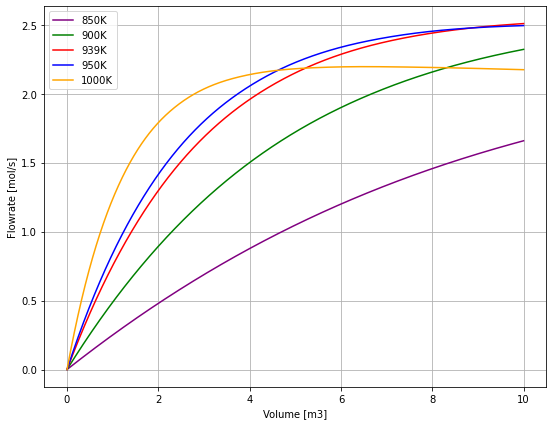

In [18]:
plt.figure(12, figsize = (9, 7))
plt.plot(Vspan1, FSt5*1000, color = 'purple', label = '850K')
plt.plot(Vspan1, FSt2*1000, color = 'green', label = '900K')
plt.plot(Vspan1, FSt1*1000, color = 'red', label = '939K')
plt.plot(Vspan1, FSt3*1000, color = 'blue', label = '950K')
plt.plot(Vspan1, FSt4*1000, color = 'orange', label = '1000K')
plt.legend(loc = 'best')
plt.xlabel('Volume [m3]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

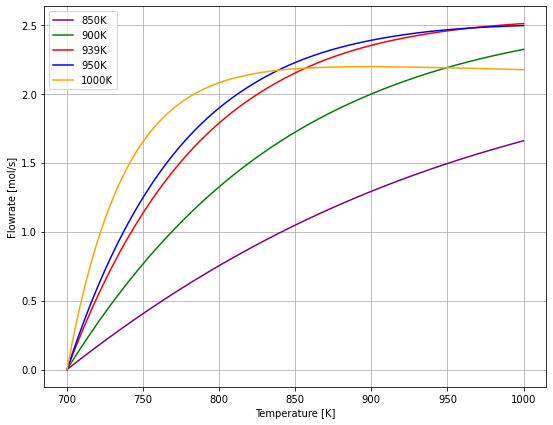

In [42]:
plt.figure(13, figsize = (9, 7))
plt.plot(T1range, FSt5*1000, color = 'purple', label = '850K')
plt.plot(T1range, FSt2*1000, color = 'green', label = '900K')
plt.plot(T1range, FSt1*1000, color = 'red', label = '939K')
plt.plot(T1range, FSt3*1000, color = 'blue', label = '950K')
plt.plot(T1range, FSt4*1000, color = 'orange', label = '1000K')
plt.legend(loc = 'best')
plt.xlabel('Temperature [K]')
plt.ylabel('Flowrate [mol/s]')
plt.grid()

plt.savefig('Temperature Effect.png', dpi=400, bbox_inches='tight')

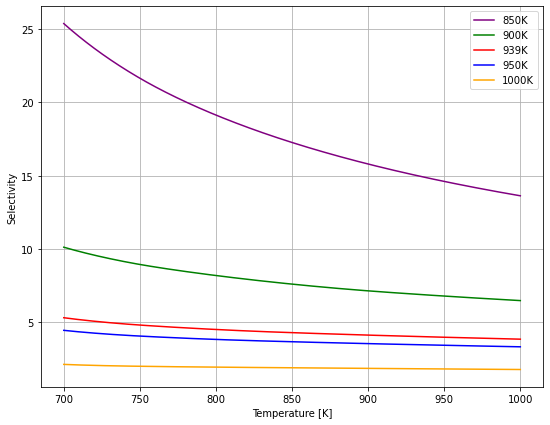

In [43]:
plt.figure(14, figsize = (9, 7))
plt.plot(T1range, S5, color = 'purple', label = '850K')
plt.plot(T1range, S2, color = 'green', label = '900K')
plt.plot(T1range, S1, color = 'red', label = '939K')
plt.plot(T1range, S3, color = 'blue', label = '950K')
plt.plot(T1range, S4, color = 'orange', label = '1000K')
plt.legend(loc = 'best')
plt.xlabel('Temperature [K]')
plt.ylabel('Selectivity')
plt.grid()

plt.savefig('Temperature Effect Selectivity.png', dpi=400, bbox_inches='tight')

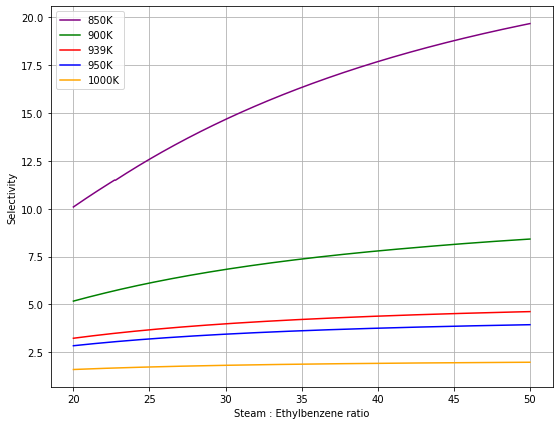

In [27]:
plt.figure(15, figsize = (9, 7))
plt.plot(rval, S850, color = 'purple', label = '850K')
plt.plot(rval, S900, color = 'green', label = '900K')
plt.plot(rval, S939, color = 'red', label = '939K')
plt.plot(rval, S950, color = 'blue', label = '950K')
plt.plot(rval, S1000, color = 'orange', label = '1000K')
plt.legend(loc = 'best')
plt.xlabel('Steam : Ethylbenzene ratio')
plt.ylabel('Selectivity')
plt.grid()

plt.savefig('Different Selectivity.png', dpi=400, bbox_inches='tight')

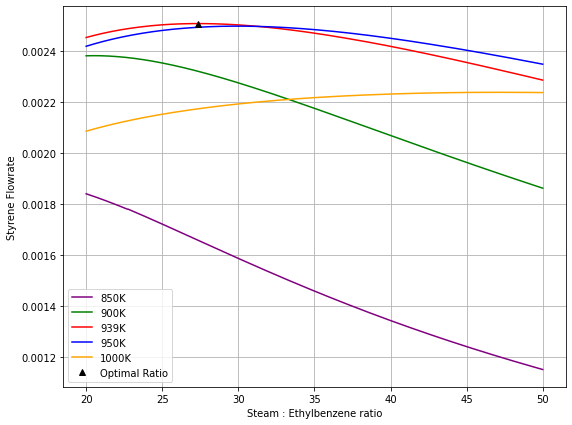

In [37]:
plt.figure(15, figsize = (9, 7))
plt.plot(rval, F850, color = 'purple', label = '850K')
plt.plot(rval, F900, color = 'green', label = '900K')
plt.plot(rval, F939, color = 'red', label = '939K')
plt.plot(rval, F950, color = 'blue', label = '950K')
plt.plot(rval, F1000, color = 'orange', label = '1000K')
plt.plot(rOpt, FSTmax,  '^', color = 'black', label = 'Optimal Ratio')
plt.legend(loc = 'best')
plt.xlabel('Steam : Ethylbenzene ratio')
plt.ylabel('Styrene Flowrate')
plt.grid()

plt.savefig('Different Flowrates.png', dpi=300, bbox_inches='tight')